# Notebook demo de sesion de registro en campo



In [2]:
import sounddevice as sd       
from acousticfield.session import RecordingSession
from acousticfield.io import play
from acousticfield.process import make_filterbank
from acousticfield.room import paracoustic
from acousticfield.display import *

# Ajuste de sounddevice
Elegir la interfaz de entrada salida si es necesario con sd.default_device[devicein,deviceout] usando los numeros que devuelve query_devices()

In [4]:
sd.query_devices()

   0 HDA Intel PCH: ALC1220 Analog (hw:0,0), ALSA (2 in, 6 out)
   1 HDA Intel PCH: ALC1220 Digital (hw:0,1), ALSA (0 in, 2 out)
   2 HDA Intel PCH: ALC1220 Alt Analog (hw:0,2), ALSA (2 in, 0 out)
   3 HDA Intel PCH: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
   4 HDA Intel PCH: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)
   5 HDA Intel PCH: HDMI 2 (hw:0,8), ALSA (0 in, 8 out)
   6 HDA Intel PCH: HDMI 3 (hw:0,9), ALSA (0 in, 8 out)
   7 HDA Intel PCH: HDMI 4 (hw:0,10), ALSA (0 in, 8 out)
   8 HDA NVidia: HDMI 0 (hw:1,3), ALSA (0 in, 8 out)
   9 HDA NVidia: HDMI 1 (hw:1,7), ALSA (0 in, 8 out)
  10 HDA NVidia: HDMI 2 (hw:1,8), ALSA (0 in, 8 out)
  11 HDA NVidia: HDMI 3 (hw:1,9), ALSA (0 in, 8 out)
  12 HDA NVidia: HDMI 4 (hw:1,10), ALSA (0 in, 8 out)
  13 HDA NVidia: HDMI 5 (hw:1,11), ALSA (0 in, 8 out)
  14 HDA NVidia: HDMI 6 (hw:1,12), ALSA (0 in, 8 out)
  15 Logitech BRIO: USB Audio (hw:2,0), ALSA (2 in, 0 out)
  16 sysdefault, ALSA (128 in, 128 out)
  17 front, ALSA (0 in, 6 out)
  18 surround21, A

In [ ]:
#sd.default.device = [2,2]
fs = 48000

# Inicio de Sesion

Generacion de Metadata y nombres de archivo para los registros

In [3]:
s = session.RecordingSession("CETC1", ["front", "rear","left","right"], ["center", "left"])

generating sweep sweep_x1_48k_10s_30_22k
Warning RMS pedido mayor al RMS de corte que es -3.44 dB 
Sweep RMS = -3.44 dB 
Sweep generated with 576000 samples.
Total signal with 1 repetitions has a duration of 12.00 seconds


In [4]:
ir1 = s.record_ir(4,2,loopback=1,take=3)

Recording ... CETC1_Sright_Mleft_2ch_loop_(3)
finished
Extracting ---> CETC1_Sright_Mleft_2ch_loop_(3)
DONE


In [5]:
s.list_recordings()

0:CETC1_Sright_Mleft_2ch_loop_(3)


In [6]:
vars(s)

{'session_id': 'CETC1',
 'speakers': ['front', 'rear', 'left', 'right'],
 'microphones': ['center', 'left'],
 'speaker_pos': [0, 0],
 'microphone_pos': [0, 0],
 'input_channels': [0, 1],
 'output_channels': [0, 1],
 'loopback': None,
 'sampling_rate': 48000,
 'date': '2023-05-20',
 'hour': '01:36:07',
 'comments': '',
 'sweepfile': 'sweep_x1_48k_10s_30_22k',
 'rpath': '',
 'recordings': [['CETC1_Sright_Mleft_2ch_loop_(3)', '']]}

In [7]:
ir1.shape

(284717, 1)

In [9]:
ir2 = s.load_ir(0)

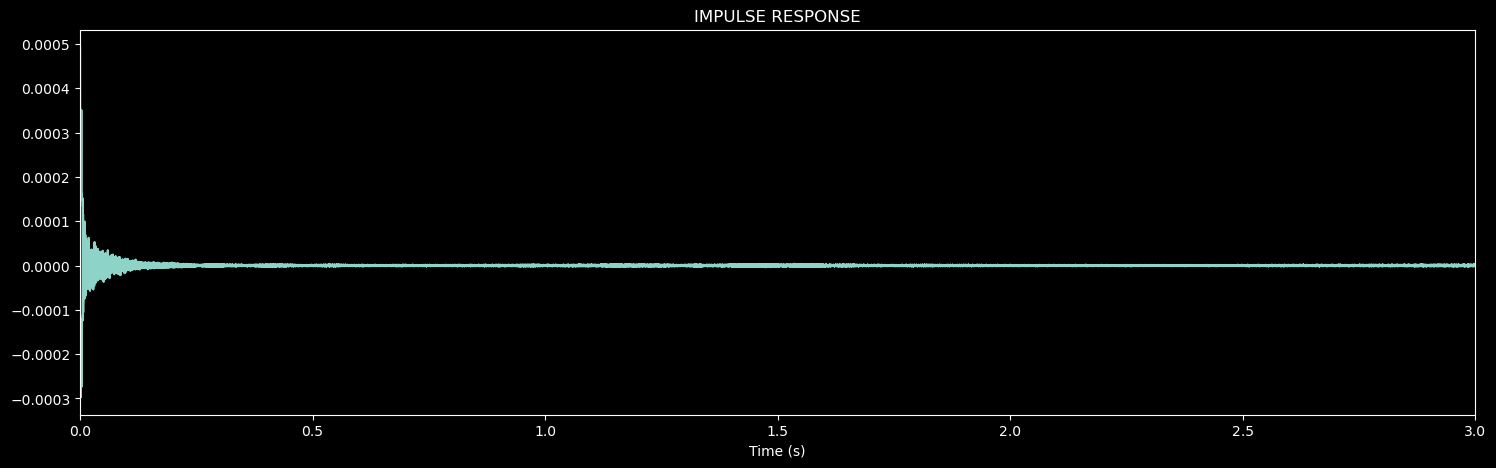

In [10]:
ir_plot(ir2,fs=s.sampling_rate)

In [11]:
from acousticfield.io import play
play(ir1,chanout=[0,1],normalized=True,fs=s.sampling_rate)

In [16]:
ir1.shape

(284717, 1)

In [19]:
echos = echo_display(ir1,0,fs=s.sampling_rate)

IndexError: index 0 is out of bounds for axis 0 with size 0

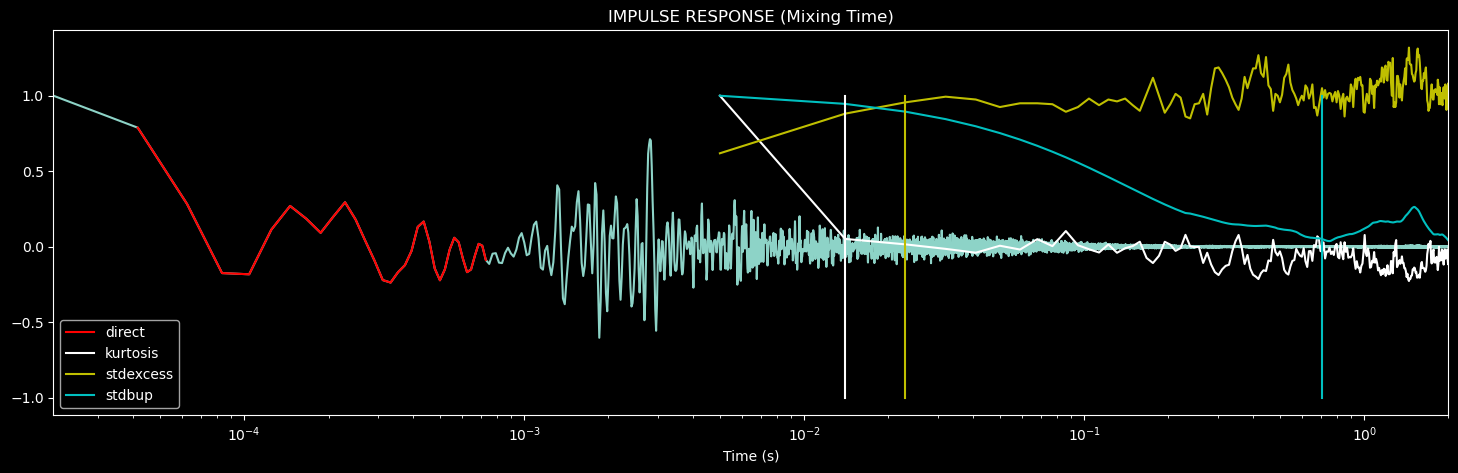

In [20]:
pstat = irstat_plot(ir1, window=0.01, overlap=0.001, logscale=True, fs=s.sampling_rate)

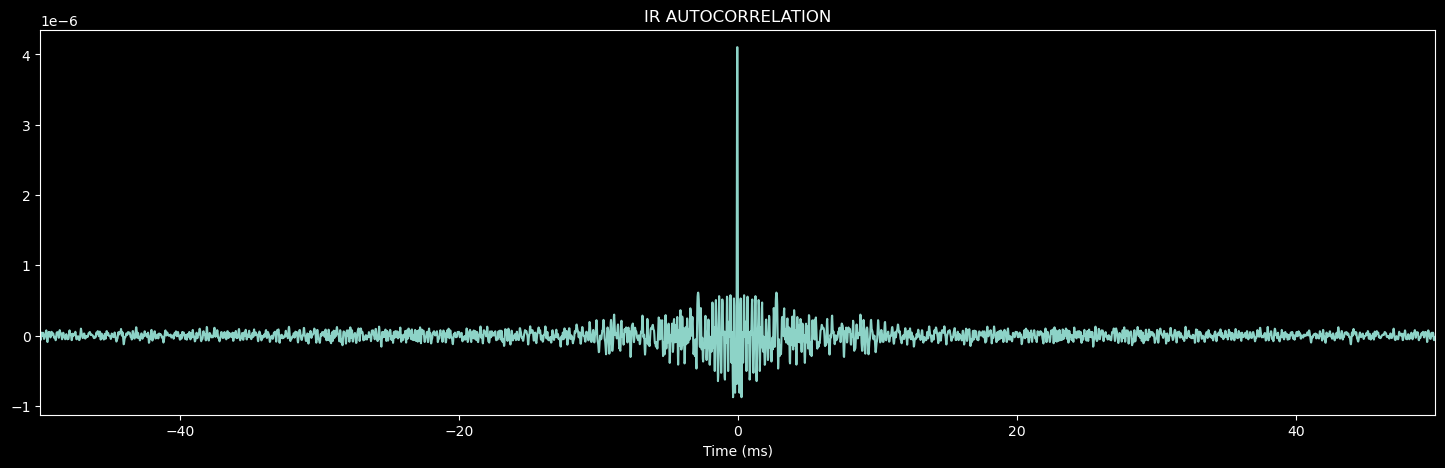

In [21]:
ac = acorr_plot(ir1,trange=0.05,fs=s.sampling_rate)

# Parametros acusticos

Calculo de los parametros acusticos usando paracoustic, el primer parametro es la RI (el array o el nombre de archivo), se puede especificarl el metodo para calcular el tiempo de reverberacion (rt30, rt20, rt15) y el banco de filtros a utilizar (el formato de nombre para el banco de filtros es fbank + frecuencia de sampleo + _ + numero de octavas + _ + numero de bandas por octavas. Por defecto el banco arranca en la octava de 62.5 para modificarlo se puede usar la funcion make_filterbank de process.

**paracoustic** devuelve un diccionario con todos los parametros por bandas, y dos columnas adicionales para ponderacion A y Flat. 

**pars_print** imprime todos los parametros (tambien se le puede pasar una lista de keys).

**pars_plot** hace graficos de los parametros que se le pasan como key.

Los parametros que se calculan son
- 'snr' relacion señal ruido en dB
- 'rt20' (o 'rt30' o 'rt15) tiempo de reverberacion en segundos
- 'edt' decaimiento temprano en segundos
- 'c50' y 'c80' claridad en dB con dos criterios
- 'ts' centro temporal en segundos
- 'dr' relacion directo reverberante en dB

Pero paracoustic tambien devuelve:
- 'rvalue' coeficiente de regresion del ajuste del decaimiento (puede incorporarse a parsprint)
- 'schr' integral de Schroeder para graficar el decaimiento
- 'lfit' 'tfit' intersecciones con tiempo y nivel donde realiza el ajuste de decaimiento

La funcion **parsdecay_plot** muestra los decaimientos por bandas en un multiplot.

En todos los casos muestra los datos de un solo canal (por defecto el canal 0 pero se puede especificar con el parametro chan)

In [ ]:
#from acousticfield.process import make_filterbank
make_filterbank(fmin=62.5,noct=9,bwoct=1,fs=fs,bankname='fbank48k_9_1',show=True)

In [ ]:
pars = paracoustic('ri_tanque_distancia_frente_4', method='rt20',bankname='fbank96k_9_1')

In [ ]:
pars_print(pars,chan=1)

In [ ]:
pars_plot(pars,['snr','rt30','c80','ts','dr'],chan=0)

In [ ]:
parsdecay_plot(pars,fs=fs)

In [ ]:
# Con Golay no llega a un SNR de 20 (esta grabado a baja intensidad)
pars_golay = paracoustic('ri_L1_golay', method='rt15',bankname='fbank96k_9_1')

In [ ]:
parsdecay_plot(pars_golay,fs=fs)

# Funcion Transferencia

La funcion **spectrum_plot** grafica y devuelve el espectro (power spectral density) y la fft como amplitud y fase de una señal arbitraria (multicanal)

Si pasamos la respuesta impulso como señal recibimos la funcion de transferencia. El primer parametro puede ser un array o un nombre de archivo. Si es array hay que especificar la frecuencia de sampleo. logscale se refiere a la escala de frecuencias (la magnitud esta en dB). fmax es la frecuencia maxima que muestra en el grafico pero calcula todo hasta Nyquist. Devuelve un diccionario con keys 'f' 's' 'amplitude' 'phase' correspondientes a la lista de frecuencias, y arrays 2D (un canal por fila) con el espectro de potencias, la amplitud y la fase de la fft respectivamente.
bajo

In [ ]:
sp = spectrum_plot(ri_L1, logscale=True, fmax=4000, fs=fs)

# Espectrograma

Como en el caso anterior, **spectrogram_plot** grafica y devuelve el espectrograma (ahora de un solo canal que se puede especificar con el parametro chan). 
recibe como parametros ademas de la señal en primero lugar, el tamaño de ña ventana en samples 'window', el overlap de las ventanas en samples 'overlap' la frecuencia de sampleo y el rango en dB 'lrange'. 'normalize' = True normaliza la salida en amplitud.
Atencion, por ahora necesita el array (no el nombre de archivo)

In [ ]:
spec = spectrogram_plot(ri_L1,4096,400,chan=0,normalized=True,fs=fs,lrange=100,fmax=22000)